# ⬇️ Imports

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import sys
sys.path.append('/home/anouchka/code/qadnguyen/realdata')
from prop_value.ml_logic.preprocessor import preprocess_data, clean_data


import warnings
warnings.filterwarnings('ignore')


# ✅ Downloading the data

In [3]:
# # Get the data from the csv file
# dvf_full_raw = pd.read_csv('../raw_data/dvf_full_raw.csv')

# dvf_full_raw.shape

In [95]:
df_93_raw = pd.read_csv('../raw_data/dvf_93.csv')

In [3]:
# df = pd.read_csv('../raw_data/dvf_full_raw.csv')

KeyboardInterrupt: 

# 🔎 Exploring 1 region

In [6]:
df_93_raw.columns

Index(['Unnamed: 0', 'id_mutation', 'date_mutation', 'numero_disposition',
       'nature_mutation', 'valeur_fonciere', 'adresse_numero',
       'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie',
       'code_postal', 'code_commune', 'nom_commune', 'code_departement',
       'ancien_code_commune', 'ancien_nom_commune', 'id_parcelle',
       'ancien_id_parcelle', 'numero_volume', 'lot1_numero',
       'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez',
       'lot3_numero', 'lot3_surface_carrez', 'lot4_numero',
       'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez',
       'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati',
       'nombre_pieces_principales', 'code_nature_culture', 'nature_culture',
       'code_nature_culture_speciale', 'nature_culture_speciale',
       'surface_terrain', 'longitude', 'latitude', 'section_prefixe'],
      dtype='object')

# 🔅 Preprocessing

## 🧹 Keep only useful columns and rows and translate

### Removing columns

In [7]:
keep_col =['id_mutation',
            'date_mutation',
            'nature_mutation',
            'valeur_fonciere',
            'code_postal',
            'code_commune',
            'code_departement',
            'type_local',
            'surface_reelle_bati',
            'nombre_pieces_principales',
            'surface_terrain',
            'longitude',
            'latitude']
df_93 = df_93_raw[keep_col]

df_93.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   id_mutation                271360 non-null  object
 1   date_mutation              271360 non-null  object
 2   nature_mutation            271360 non-null  object
 3   valeur_fonciere            260764 non-null  object
 4   code_postal                260677 non-null  object
 5   code_commune               271360 non-null  object
 6   code_departement           271360 non-null  object
 7   type_local                 216444 non-null  object
 8   surface_reelle_bati        135227 non-null  object
 9   nombre_pieces_principales  216216 non-null  object
 10  surface_terrain            82186 non-null   object
 11  longitude                  262485 non-null  object
 12  latitude                   262485 non-null  object
dtypes: object(13)
memory usage: 26.9+ MB


### Translate column-names

In [8]:
df_93.columns = ['id', 'date', 'built', 'price', 'postal_code',
                'city', 'region', 'property_type',
                'living_area', 'number_of_rooms', 'land_area',
                'longitude', 'latitude']

### Remove non-representative rows

In [9]:
df_93.shape

(271360, 13)

We want to keep only :
- Houses and appartments + Dépendances
- Normal sales and off-plan sales
- Sales with only one unit XXX

In [10]:
df_93.property_type.unique()

array([nan, 'Appartement', 'Dépendance',
       'Local industriel. commercial ou assimilé', 'Maison', 'type_local'],
      dtype=object)

In [11]:
print('Shape before the masks : ', df_93.shape)
print('Shape only normal sales', df_93[((df_93['built'] == "Vente") | (df_93['built'] == "Vente en l'état futur d'achèvement"))].shape)
print('Shape only house and appartments + dependencies', df_93[((df_93['property_type'] == 'Appartement') | (df_93['property_type'] == 'Maison')| (df_93['property_type'] == 'Dépendance'))].shape)

Shape before the masks :  (271360, 13)
Shape only normal sales (268269, 13)
Shape only house and appartments + dependencies (204042, 13)


In [12]:
df_useful = df_93[((df_93['built'] == "Vente") | (df_93['built'] == "Vente en l'état futur d'achèvement")) &
                    ((df_93['property_type'] == 'Appartement') | (df_93['property_type'] == 'Maison')  | (df_93['property_type'] == 'Maison')| (df_93['property_type'] == 'Dépendance'))]
df_useful.shape

(201418, 13)

In [13]:
## checking that the masks worked correctly
print(df_useful['built'].unique())
print(df_useful['property_type'].unique())


['Vente' "Vente en l'état futur d'achèvement"]
['Appartement' 'Dépendance' 'Maison']


### Translating the values

In [14]:
trans_dict_built = {'Vente' : 'built',
                    "Vente en l'état futur d'achèvement" : 'off-plan'}
trans_dict_type = {'Appartement' : 'appartment',
                   'Maison' : 'house',
                   'Dépendance' : 'dep'}
df_useful= df_useful.replace({'built' : trans_dict_built,
                             'property_type' : trans_dict_type})

In [15]:
## checking that the translation worked correctly
print(df_useful['built'].unique())
print(df_useful['property_type'].unique())

['built' 'off-plan']
['appartment' 'dep' 'house']


In [16]:
print(f'Number of elements that have been sold : {df_useful.shape[0]}')

Number of elements that have been sold : 201418


In [17]:
print(f'Number of unique sale ids : {df_useful.id.nunique()}.')

Number of unique sale ids : 62455.


# 🤓 Feature engineering

1. number of dependencies
2. garden or not --> ???

## 🛖 number of dependencies

In [18]:
mask_house = df_useful.property_type == 'house'
mask_app = df_useful.property_type == 'appartment'
mask_dep = df_useful.property_type == 'dep'

In [19]:
#find the number of houses per id
num_of_houses_df = df_useful[['id','property_type']][mask_house].groupby(by = 'id', as_index = False).count()
num_of_houses_df.value_counts()
num_of_houses_df.columns = ['id', 'nb_of_house']
num_of_houses_df.head()

,id,nb_of_house
0,2018-697286,3
1,2018-697295,2
2,2018-697297,2
3,2018-697301,2
4,2018-697310,2


In [20]:
#find the number of appartments per id
num_of_app_df = df_useful[['id','property_type']][mask_app].groupby(by = 'id', as_index = False).count()
num_of_app_df.value_counts()
num_of_app_df.columns = ['id', 'nb_of_app']
num_of_app_df.head()

,id,nb_of_app
0,2018-697281,3
1,2018-697282,3
2,2018-697283,3
3,2018-697284,3
4,2018-697287,2


In [21]:
#find the number of dep per id
num_of_dep_df = df_useful[['id','property_type']][mask_dep].groupby(by = 'id', as_index = False).count()
num_of_dep_df.value_counts()
num_of_dep_df.columns = ['id', 'nb_of_dep']
num_of_dep_df.head()

,id,nb_of_dep
0,2018-697281,3
1,2018-697283,3
2,2018-697284,3
3,2018-697287,2
4,2018-697290,2


In [22]:
num_of_dep_df.id.nunique()

34073

➕ adding columns to df_useful

In [23]:
df_feat = df_useful.merge(num_of_houses_df, on = 'id', how = 'outer')
df_feat = df_feat.merge(num_of_app_df, on = 'id', how = 'outer')
df_feat = df_feat.merge(num_of_dep_df, on = 'id', how = 'outer')
df_feat.sample(5)

,id,date,built,price,postal_code,city,region,property_type,living_area,number_of_rooms,land_area,longitude,latitude,nb_of_house,nb_of_app,nb_of_dep
47645,2018-707584,2018-10-19,built,182000.0,93330.0,93050,93,appartment,105.0,7.0,NaN,2.530274,48.866094,NaN,3.0,3.0
54870,2018-709206,2018-08-29,built,243000.00,93110,93064,93,dep,NaN,0,NaN,2.4831510,48.8728020,NaN,3.0,3.0
2366,2018-697557,2018-07-17,built,NaN,93230.0,93063,93,appartment,80.0,5.0,3959.0,2.433741,48.89136,64.0,7452.0,1058.0
25807,2018-702903,2018-11-08,built,133000.0,93350.0,93013,93,appartment,32.0,2.0,NaN,2.424835,48.936826,NaN,3.0,NaN
36954,2018-705104,2018-10-11,built,550000.00,93290,93073,93,appartment,54.00,3,479.00,2.5610560,48.9624430,4.0,24.0,NaN


In [24]:
df_feat.fillna({'nb_of_house' : 0, 'nb_of_app' : 0, 'nb_of_dep' : 0, 'land_area' : 0}, inplace=True)

In [25]:
# remove lines with multiple houses or appartments in same sale_id
df_feat['nb_of_units'] = df_feat.nb_of_app+df_feat.nb_of_house
mask_units = (df_feat['nb_of_units'] == 1)
df_filtered = df_feat[mask_units]
df_filtered.shape

(60127, 17)

In [26]:
df_filtered.sample(10)

,id,date,built,price,postal_code,city,region,property_type,living_area,number_of_rooms,land_area,longitude,latitude,nb_of_house,nb_of_app,nb_of_dep,nb_of_units
135460,2022-1533051,2022-02-04,built,194000.00,93350,93013,93,appartment,77.00,3,0,2.4279430,48.9350400,0.0,1.0,1.0,1.0
129782,2021-1603965,2021-12-13,built,600000.0,93320.0,93057,93,house,120.0,4.0,443.0,2.504688,48.899923,1.0,0.0,0.0,1.0
158309,2019-1417854,2019-04-12,built,85000.00,93400,93070,93,appartment,18.00,1,0,2.3339050,48.9012090,0.0,1.0,0.0,1.0
194778,2019-1433386,2019-03-21,off-plan,267525.0,93110.0,93064,93,dep,NaN,0.0,0,2.487046,48.865703,0.0,1.0,1.0,1.0
128433,2021-1603059,2021-12-03,built,320000.0,93160.0,93051,93,dep,NaN,0.0,0,2.574205,48.831552,0.0,1.0,4.0,1.0
106930,2020-1355507,2020-06-23,built,171900.00,93270,93071,93,appartment,80.00,4,0,2.5509130,48.9431830,0.0,1.0,1.0,1.0
139804,2022-1548833,2022-09-27,built,285000.0,93220.0,93032,93,dep,NaN,0.0,509.0,2.545809,48.893874,1.0,0.0,2.0,1.0
191732,2019-1431207,2019-09-18,built,207068.97,93160.0,93051,93,dep,NaN,0.0,0,2.569599,48.842485,0.0,1.0,2.0,1.0
112613,2020-1359847,2020-04-21,built,145000.0,93160.0,93051,93,dep,NaN,0.0,0,2.5656,48.843514,0.0,1.0,1.0,1.0
156713,2019-1416601,2019-01-17,built,183000.00,93120,93027,93,dep,NaN,0,0,2.3800680,48.9306970,0.0,1.0,1.0,1.0


In [27]:
#filter out the dependencies
filter_type = (df_filtered['property_type'] != 'dep')
df_filtered = df_filtered[filter_type]
df_filtered.shape

(36309, 17)

In [28]:
df_filtered_drop = df_filtered.drop(columns = ['nb_of_units', 'nb_of_app', 'nb_of_house'])
df_filtered_drop.shape
df_filtered_drop.sample(5)

,id,date,built,price,postal_code,city,region,property_type,living_area,number_of_rooms,land_area,longitude,latitude,nb_of_dep
158556,2019-1417996,2019-04-01,built,223000.00,93400,93070,93,appartment,45.00,2,0,2.3387470,48.9067160,1.0
152388,2023-516452,2023-03-13,built,150000.00,93260,93045,93,appartment,21.00,2,0,2.4132300,48.8808210,0.0
126522,2021-1601835,2021-10-26,built,325950.0,93110.0,93064,93,appartment,65.0,3.0,0,2.481825,48.876992,1.0
145637,2022-1552979,2022-11-18,built,234000.0,93250.0,93077,93,appartment,56.0,3.0,0,2.509527,48.888574,1.0
89053,2022-1538507,2022-04-15,built,202000.0,93240.0,93072,93,appartment,66.0,3.0,0,2.380785,48.958545,1.0


In [29]:
df_filtered_drop.duplicated().sum()

0

## 🌼 Adding garden feature ? TODO : Nan = 0, other number = 1

❓❔❓ relation between land_area and living_area

In [30]:
df_filtered_drop.duplicated().sum()

0

In [31]:
df_filtered_drop.isnull().sum()/len(df_filtered_drop) # 76 % of land_area is null

id                 0.000000
date               0.000000
built              0.000000
price              0.000441
postal_code        0.000000
city               0.000000
region             0.000000
property_type      0.000000
living_area        0.000028
number_of_rooms    0.000028
land_area          0.000000
longitude          0.006279
latitude           0.006279
nb_of_dep          0.000000
dtype: float64

In [32]:
mask_house = df_filtered_drop.property_type == 'house'
df_filtered_drop[mask_house].isnull().sum()/len(df_filtered_drop[mask_house]) # 13 % of land_area is null

id                 0.000000
date               0.000000
built              0.000000
price              0.000407
postal_code        0.000000
city               0.000000
region             0.000000
property_type      0.000000
living_area        0.000000
number_of_rooms    0.000000
land_area          0.000000
longitude          0.009459
latitude           0.009459
nb_of_dep          0.000000
dtype: float64

In [33]:
mask_appartments = df_filtered_drop.property_type == 'appartment'
df_filtered_drop[mask_appartments].isnull().sum()/len(df_filtered_drop[mask_appartments]) # 99 % of land_area is null

id                 0.000000
date               0.000000
built              0.000000
price              0.000453
postal_code        0.000000
city               0.000000
region             0.000000
property_type      0.000000
living_area        0.000038
number_of_rooms    0.000038
land_area          0.000000
longitude          0.005099
latitude           0.005099
nb_of_dep          0.000000
dtype: float64

In [34]:
########################################### TO DO : garden 1 or 0

## 🚮 Dropping duplicates and NaNs

➡️ 76% of the land_area is Null... --> drop the column land_area ?

In [35]:
df_final = df_filtered_drop.drop(columns = ['land_area', 'id'])
df_clean = df_final.dropna()
df_clean.shape

(36064, 12)

## 🧮 Count summary

In [36]:
print('Number of lines before the masks : ', df_93.shape[0])
print('Number of lines of only normal sales : ', df_93[((df_93['built'] == "Vente") | (df_93['built'] == "Vente en l'état futur d'achèvement"))].shape[0])
print('Number of lines of only house and appartments + dependencies : ', df_93[((df_93['property_type'] == 'Appartement') | (df_93['property_type'] == 'Maison')| (df_93['property_type'] == 'Dépendance'))].shape[0])
print(f'Number of unique sale ids : {df_clean.shape[0]}')

Number of lines before the masks :  271360
Number of lines of only normal sales :  268269
Number of lines of only house and appartments + dependencies :  204042
Number of unique sale ids : 36064


## 💰 Create € / sq m

In [37]:
df_clean[['price', 'living_area']] = df_clean[['price', 'living_area']].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('float64'))

df_clean['price_per_m2'] = df_clean.price / df_clean.living_area

In [38]:
df_clean.sample(5)

,date,built,price,postal_code,city,region,property_type,living_area,number_of_rooms,longitude,latitude,nb_of_dep,price_per_m2
150299,2022-06-02,built,149000.0,93430.0,93079,93,appartment,43.0,2.0,2.340242,48.952251,2.0,3465.116279
122926,2021-10-14,built,415110.0,93340.0,93062,93,appartment,100.0,4.0,2.525308,48.899451,3.0,4151.100000
150236,2022-06-20,built,234000.0,93120.0,93027,93,appartment,82.0,4.0,2.394098,48.931135,1.0,2853.658537
186250,2019-09-23,built,340000.0,93250,93077,93,house,77.0,4,2.5105360,48.8783110,0.0,4415.584416
119071,2020-04-17,built,245000.0,93110.0,93064,93,appartment,89.0,4.0,2.470823,48.877821,0.0,2752.808989


## 🦖 Changing everything to the right type

In [39]:
df_clean.columns

Index(['date', 'built', 'price', 'postal_code', 'city', 'region',
       'property_type', 'living_area', 'number_of_rooms', 'longitude',
       'latitude', 'nb_of_dep', 'price_per_m2'],
      dtype='object')

In [40]:
#changing evething to the right type --> TO DO:should this go to params?
col_float = ['price', 'longitude', 'latitude', 'living_area', 'price_per_m2' ]
col_string = ['built','city', 'region','property_type']
col_date = ['date']
col_int = ['postal_code', 'nb_of_dep', 'number_of_rooms']
#formating data types
df_clean[col_float] = df_clean[col_float].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('float64'))
df_clean[col_date]= df_clean[col_date].apply(lambda x: pd.to_datetime(x, errors='coerce'))
df_clean[col_int]= df_clean[col_int].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('int64'))

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36064 entries, 378 to 201417
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             36064 non-null  datetime64[ns]
 1   built            36064 non-null  object        
 2   price            36064 non-null  float64       
 3   postal_code      36064 non-null  int64         
 4   city             36064 non-null  object        
 5   region           36064 non-null  object        
 6   property_type    36064 non-null  object        
 7   living_area      36064 non-null  float64       
 8   number_of_rooms  36064 non-null  int64         
 9   longitude        36064 non-null  float64       
 10  latitude         36064 non-null  float64       
 11  nb_of_dep        36064 non-null  int64         
 12  price_per_m2     36064 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(4)
memory usage: 3.9+ MB


## drop outliers
1. find price per sq m - DONE
2. group by each postal code
3. percentile 96 % of this new feature
4. drop everything above it

In [41]:
df_quantile = df_clean[['postal_code', 'price_per_m2']].groupby(by = df_clean.postal_code, as_index=False).quantile(.95)
df_quantile.columns = ['postal_code', 'p95']
df_quantile.head()

,postal_code,p95
0,93000.0,7913.684211
1,93100.0,10056.962025
2,93110.0,6209.340659
3,93120.0,5208.333333
4,93130.0,6171.212121


In [42]:
df_clean_merged = df_quantile.merge(right = df_clean, on = 'postal_code')
df_clean_merged.head()

,postal_code,p95,date,built,price,city,region,property_type,living_area,number_of_rooms,longitude,latitude,nb_of_dep,price_per_m2
0,93000.0,7913.684211,2018-07-09,off-plan,252760.4,93008,93,appartment,64.0,3,2.413402,48.919067,1,3949.381250
1,93000.0,7913.684211,2018-07-11,off-plan,138000.0,93008,93,appartment,25.0,1,2.413402,48.919067,0,5520.000000
2,93000.0,7913.684211,2018-07-12,off-plan,228370.0,93008,93,appartment,61.0,3,2.457606,48.902013,1,3743.770492
3,93000.0,7913.684211,2018-07-05,built,127000.0,93008,93,appartment,45.0,2,2.442712,48.908689,1,2822.222222
4,93000.0,7913.684211,2018-07-06,off-plan,277000.0,93008,93,appartment,84.0,4,2.412198,48.916855,1,3297.619048


In [43]:
df_clean_merged.shape

(36064, 14)

In [44]:
# drop the outliers
mask_outliers = (df_clean_merged.price_per_m2 < df_clean_merged.p95)
df_without_outliers = df_clean_merged[mask_outliers]

In [45]:
df_clean_merged.shape, df_without_outliers.shape

((36064, 14), (34241, 14))

In [46]:
# def filter_top_4_percent(df, column_name):
#     threshold = df[column_name].quantile(0.96)
#     return df[df[column_name] <= threshold]

# df_without_outliers_2 = filter_top_4_percent(df_clean_merged, '')

In [47]:
df_without_outliers.shape[0]/df_clean_merged.shape[0]

0.949450976042591

In [48]:
df_without_outliers.head()

,postal_code,p95,date,built,price,city,region,property_type,living_area,number_of_rooms,longitude,latitude,nb_of_dep,price_per_m2
0,93000.0,7913.684211,2018-07-09,off-plan,252760.4,93008,93,appartment,64.0,3,2.413402,48.919067,1,3949.381250
1,93000.0,7913.684211,2018-07-11,off-plan,138000.0,93008,93,appartment,25.0,1,2.413402,48.919067,0,5520.000000
2,93000.0,7913.684211,2018-07-12,off-plan,228370.0,93008,93,appartment,61.0,3,2.457606,48.902013,1,3743.770492
3,93000.0,7913.684211,2018-07-05,built,127000.0,93008,93,appartment,45.0,2,2.442712,48.908689,1,2822.222222
4,93000.0,7913.684211,2018-07-06,off-plan,277000.0,93008,93,appartment,84.0,4,2.412198,48.916855,1,3297.619048


In [49]:
df_clean_merged.head()

,postal_code,p95,date,built,price,city,region,property_type,living_area,number_of_rooms,longitude,latitude,nb_of_dep,price_per_m2
0,93000.0,7913.684211,2018-07-09,off-plan,252760.4,93008,93,appartment,64.0,3,2.413402,48.919067,1,3949.381250
1,93000.0,7913.684211,2018-07-11,off-plan,138000.0,93008,93,appartment,25.0,1,2.413402,48.919067,0,5520.000000
2,93000.0,7913.684211,2018-07-12,off-plan,228370.0,93008,93,appartment,61.0,3,2.457606,48.902013,1,3743.770492
3,93000.0,7913.684211,2018-07-05,built,127000.0,93008,93,appartment,45.0,2,2.442712,48.908689,1,2822.222222
4,93000.0,7913.684211,2018-07-06,off-plan,277000.0,93008,93,appartment,84.0,4,2.412198,48.916855,1,3297.619048


In [50]:
df_clean_merged.price_per_m2.sort_values(ascending = False).head(20)

28954    1.106875e+06
29233    1.085340e+06
8951     4.300000e+05
21223    4.198361e+05
13773    3.100000e+05
29227    3.050948e+05
28569    2.916667e+05
2299     2.850000e+05
195      2.739388e+05
10349    2.452875e+05
21381    1.800000e+05
21942    1.714286e+05
13711    1.687500e+05
15080    1.674100e+05
32487    1.587500e+05
24240    1.472500e+05
5558     1.217105e+05
10452    1.154593e+05
1643     1.065900e+05
13778    9.588579e+04
Name: price_per_m2, dtype: float64

In [51]:
df_without_outliers.price_per_m2.sort_values(ascending = False).head(30)

938      10000.000000
2285     10000.000000
2119     10000.000000
1187     10000.000000
1182      9993.789474
3188      9961.538462
2306      9955.357143
829       9944.444444
2215      9925.373134
1567      9903.846154
1548      9895.833333
2014      9894.736842
1911      9890.625000
19259     9887.640449
2349      9873.333333
3330      9852.941176
1985      9838.709677
882       9814.814815
1691      9814.814815
2638      9814.814815
3010      9814.526316
2089      9808.823529
1065      9800.000000
1717      9797.101449
1610      9790.322581
3199      9750.000000
19228     9740.259740
877       9716.346154
2105      9704.347826
2810      9701.492537
Name: price_per_m2, dtype: float64

In [52]:
# drop p95
df_without_outliers = df_without_outliers.drop(columns=['p95', 'price_per_m2'])

In [53]:
df_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34241 entries, 0 to 36062
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   postal_code      34241 non-null  float64       
 1   date             34241 non-null  datetime64[ns]
 2   built            34241 non-null  object        
 3   price            34241 non-null  float64       
 4   city             34241 non-null  object        
 5   region           34241 non-null  object        
 6   property_type    34241 non-null  object        
 7   living_area      34241 non-null  float64       
 8   number_of_rooms  34241 non-null  int64         
 9   longitude        34241 non-null  float64       
 10  latitude         34241 non-null  float64       
 11  nb_of_dep        34241 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 3.4+ MB


Dealing date_column

In [54]:
df_without_outliers.date.head()

0   2018-07-09
1   2018-07-11
2   2018-07-12
3   2018-07-05
4   2018-07-06
Name: date, dtype: datetime64[ns]

In [55]:
df_without_outliers.date.dt.day.head()

0     9
1    11
2    12
3     5
4     6
Name: date, dtype: int64

In [56]:
df_without_outliers['day'] = df_without_outliers.date.dt.day

df_without_outliers['day_sin'] = np.sin(2 * np.pi * df_without_outliers['day']/31.0)
df_without_outliers['day_cos'] = np.cos(2 * np.pi * df_without_outliers['day']/31.0)

In [57]:
df_without_outliers['month'] = df_without_outliers.date.dt.month

df_without_outliers['month_sin'] = np.sin(2 * np.pi * df_without_outliers['month']/24.0)
df_without_outliers['month_cos'] = np.cos(2 * np.pi * df_without_outliers['month']/24.0)

In [58]:
df_without_outliers['year'] = df_without_outliers.date.dt.year


In [63]:
df_without_outliers = df_without_outliers.drop(columns = ['day', 'month'])

In [59]:
df_without_outliers.year

0        2018
1        2018
2        2018
3        2018
4        2018
         ... 
36058    2019
36059    2019
36060    2019
36061    2019
36062    2019
Name: year, Length: 34241, dtype: int64

## ✨ Using the functions

In [29]:
# check if function is working :
import sys
sys.path.append('/home/anouchka/code/qadnguyen/realdata')
from prop_value.ml_logic.preprocessor import clean_data

clean_data(df_93_raw, percentile = 0.95).shape, df_without_outliers.shape

AttributeError: 'DataFrame' object has no attribute 'p04'

In [66]:
df_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34241 entries, 0 to 36062
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   postal_code      34241 non-null  float64       
 1   date             34241 non-null  datetime64[ns]
 2   built            34241 non-null  object        
 3   price            34241 non-null  float64       
 4   city             34241 non-null  object        
 5   region           34241 non-null  object        
 6   property_type    34241 non-null  object        
 7   living_area      34241 non-null  float64       
 8   number_of_rooms  34241 non-null  int64         
 9   longitude        34241 non-null  float64       
 10  latitude         34241 non-null  float64       
 11  nb_of_dep        34241 non-null  int64         
 12  day_sin          34241 non-null  float64       
 13  day_cos          34241 non-null  float64       
 14  month_sin        34241 non-null  float

In [74]:
# check if function is working :
import sys
sys.path.append('/home/anouchka/code/qadnguyen/realdata')
from prop_value.ml_logic.preprocessor import preprocess_data

data = clean_data(df_93_raw, percentile = 0.95)
print(f'shape of the cleaned data : {data.shape}')
print(data.info())

X_train_preproc_TEST, X_test_preproc_TEST, y_train_TEST, y_test_TEST, X_all_TEST, y_all_TEST, df_full_TEST = preprocess_data(data)
X_all_TEST.info()


shape of the cleaned data : (34241, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34241 entries, 0 to 36062
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   postal_code      34241 non-null  int64         
 1   date             34241 non-null  datetime64[ns]
 2   built            34241 non-null  object        
 3   price            34241 non-null  float64       
 4   city             34241 non-null  int64         
 5   region           34241 non-null  object        
 6   property_type    34241 non-null  object        
 7   living_area      34241 non-null  float64       
 8   number_of_rooms  34241 non-null  int64         
 9   longitude        34241 non-null  float64       
 10  latitude         34241 non-null  float64       
 11  nb_of_dep        34241 non-null  int64         
 12  day_sin          34241 non-null  float64       
 13  day_cos          34241 non-null  float64       
 14

# 🐧 Modelling

## 🔎 Exploring some more

In [58]:
df_clean.columns

Index(['date', 'built', 'price', 'postal_code', 'city', 'region',
       'property_type', 'living_area', 'number_of_rooms', 'longitude',
       'latitude', 'nb_of_dep', 'price_per_m2'],
      dtype='object')

In [59]:
# df_cleaned.shape # (1029674, 12)

In [60]:
# df_cleaned[mask_price].shape # (1027158, 12)

In [61]:
import matplotlib.pyplot as plt

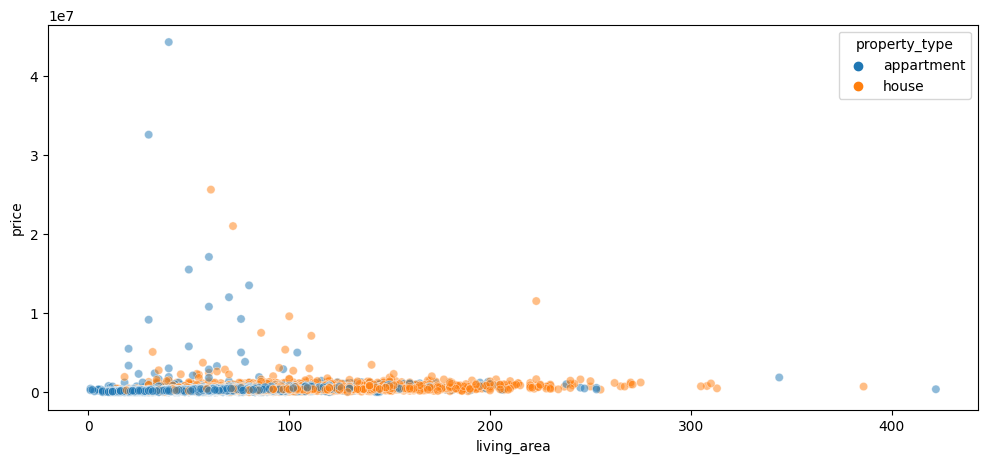

In [62]:
plt.figure(figsize = (12,5))
sns.scatterplot(df_clean['living_area'], df_clean['price'],hue = df_clean['property_type'],alpha = 0.5)
plt.show()

<AxesSubplot:xlabel='price'>

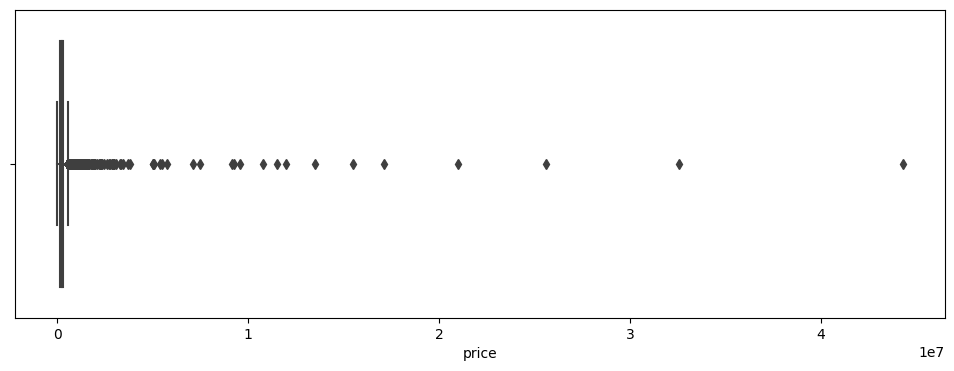

In [63]:
plt.figure(figsize = (12,4))
sns.boxplot(df_clean.price)

In [64]:
df_clean.head()

,date,built,price,postal_code,city,region,property_type,living_area,number_of_rooms,longitude,latitude,nb_of_dep,price_per_m2
378,2018-07-09,built,305000.00,93310,93061,93,appartment,81.0,4,2.406018,48.881710,1,3765.432099
385,2018-07-11,off-plan,272000.00,93170,93006,93,appartment,71.0,4,2.427005,48.873193,1,3830.985915
387,2018-07-03,off-plan,214000.00,93170,93006,93,appartment,58.0,3,2.434780,48.877092,1,3689.655172
388,2018-07-19,built,218285.28,93700,93029,93,house,77.0,6,2.452531,48.935019,0,2834.873766
389,2018-07-09,off-plan,252760.40,93000,93008,93,appartment,64.0,3,2.413402,48.919067,1,3949.381250


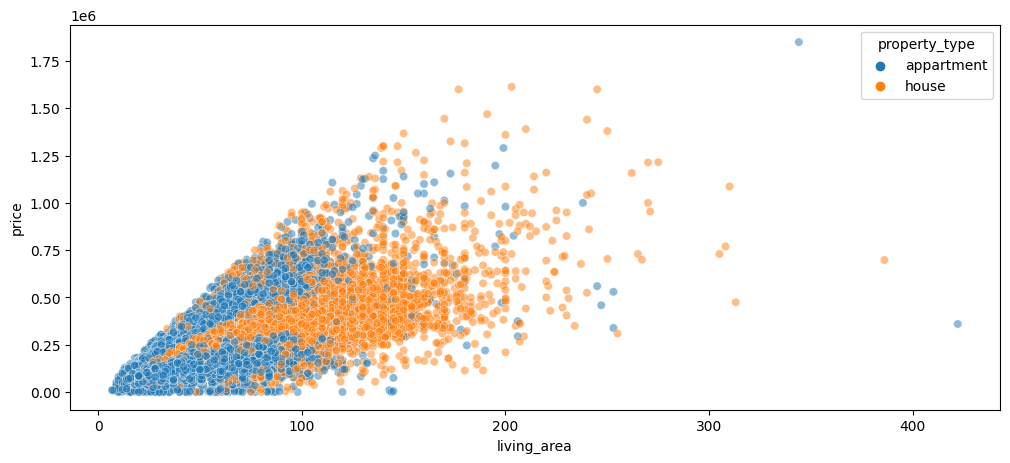

In [65]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
# mask_price = df_clean['price']<2000000 #smaller than 2 milion
# mask_area = df_clean['living_area']<500 # smaller than 500 sq meters
# df_without_outliers = df_clean[mask_price & mask_area]

# Plot Living area vs Sale price
plt.figure(figsize = (12,5))
sns.scatterplot(df_without_outliers['living_area'], df_without_outliers['price'],hue = df_without_outliers['property_type'],alpha = 0.5)
plt.show()

In [66]:
df_without_outliers['property_type'].value_counts()

appartment    25632
house          8609
Name: property_type, dtype: int64

<AxesSubplot:>

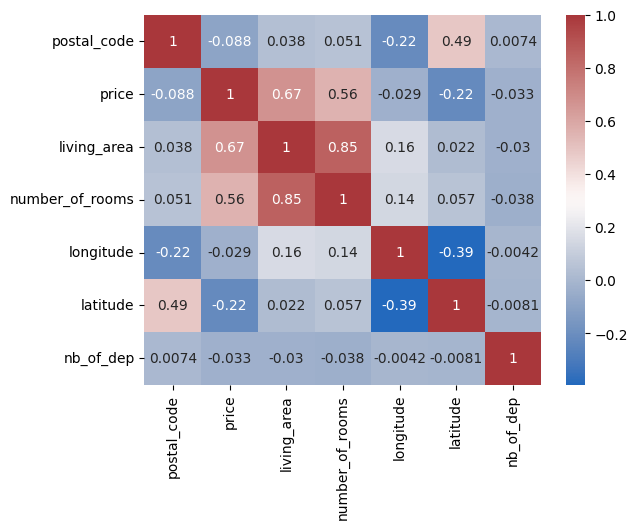

In [67]:
sns.heatmap(df_without_outliers.corr(), cmap = 'vlag', annot = True)

In [68]:
df_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34241 entries, 0 to 36062
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   postal_code      34241 non-null  float64       
 1   date             34241 non-null  datetime64[ns]
 2   built            34241 non-null  object        
 3   price            34241 non-null  float64       
 4   city             34241 non-null  object        
 5   region           34241 non-null  object        
 6   property_type    34241 non-null  object        
 7   living_area      34241 non-null  float64       
 8   number_of_rooms  34241 non-null  int64         
 9   longitude        34241 non-null  float64       
 10  latitude         34241 non-null  float64       
 11  nb_of_dep        34241 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 3.4+ MB


## Take a look at the final data

## 🐟 Naive baseline model

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
mask_price = df_clean['price'] <2000000
df_without_outliers = df_clean[mask_price]

In [71]:
X = df_without_outliers.drop(columns=['price'])
y = df_without_outliers['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
# plt.figure(figsize=(12,4))
# sns.boxplot(y)


In [73]:
mean_price = y_train.mean()
print(f"The mean price of {round(mean_price)} €")

median_price = y_train.median()
print(f"The median price of {round(median_price)} €")

The mean price of 262241 €
The median price of 230000 €


In [74]:
mean_error = y_test - mean_price
rmse_mean = ((mean_error**2).mean())**(1/2)
print(f'The rmse when always predicting the mean : {round(rmse_mean)} €.')

The rmse when always predicting the mean : 155734 €.


In [75]:
median_error = y_test - median_price
rmse_median = ((median_error**2).mean())**(1/2)
print(f'The rmse when always predicting the median : {round(rmse_median)} €.')

The rmse when always predicting the median : 159025 €.


## 🐸 Model

In [3]:
df_full_clean = pd.read_pickle('../raw_data/dvf_full_cleaned.pkl')


In [8]:
df_full_clean.price.mean()

210574.65951663736

## 💢 encode the data

In [105]:
# df_93_clean = clean_data(df_93_raw)

In [7]:
X_train_preproc, X_test_preproc, y_train, y_test, X_all, y_all, df_full = preprocess_data(df_full_clean)

MemoryError: Unable to allocate 40.1 GiB for an array with shape (1003667, 5360) and data type int64

In [5]:
df_full.shape

NameError: name 'df_full' is not defined

In [5]:
import sys
sys.path.append('/home/anouchka/code/qadnguyen/realdata')
from prop_value.ml_logic.preprocessor import preprocess_data
X_train_preproc, X_test_preproc, y_train, y_test, X_all, y_all, df_full = preprocess_data(df_full_clean)

In [6]:
# model-specific imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score


## 🌳 RandomForest on data without outliers (df_without_ouliers)

In [78]:
from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor()

model_rfr.fit(X_train_preproc, y_train)
y_pred = model_rfr.predict(X_test_preproc)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
print(f'Root Mean Squared Error: {rmse}')
print( 'Train score (R²):', model_rfr.score(X_test_preproc, y_test))
print('Cross val score mean (R²)', cross_val_score(model_rfr, X_all, y_all, cv = 5).mean())

Root Mean Squared Error: 93205.09873159761
Train score (R²): 0.6580768436832916
Cross val score mean (R²) 0.6786656682681744


## 🪃 XGBoost on data without outliers

In [50]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
model_xgb = XGBRegressor()

model_xgb.fit(X_train_preproc, y_train)
y_pred = model_xgb.predict(X_test_preproc)
mse_b = mean_squared_error(y_pred, y_test)
rmse_b = mse_b**(1/2)
print(f'Root Mean Squared Error: {rmse_b} €')
print( 'Train score (R²) : ', model_xgb.score(X_train_preproc, y_train))
print( 'Test score (R²) : ', model_xgb.score(X_test_preproc, y_test))

Root Mean Squared Error: 77652.39112014988 €
Train score (R²) :  0.8547964183561119
Test score (R²) :  0.8273180038206011


In [8]:
(((y_test.price-y_pred)**2).mean())**(1/2)

77652.39112014988

In [73]:
df_y_pred = pd.DataFrame(y_pred)
df_y_test = pd.DataFrame(y_test).reset_index().drop(columns = 'index')
df_y_pred.columns = ['price_pred']
df_y_pred['upper'] = df_y_pred.price_pred + 30000
df_y_pred['lower'] = df_y_pred.price_pred - 30000
df_prediction = pd.concat([df_y_pred, df_y_test], axis = 1)
df_prediction['in_range'] = (df_prediction.price < df_prediction.upper) & (df_prediction.price > df_prediction.lower)

df_prediction

,price_pred,upper,lower,price,in_range
0,430941.656250,460941.656250,400941.656250,547440.0,False
1,316196.281250,346196.281250,286196.281250,265000.0,False
2,276154.531250,306154.531250,246154.531250,233980.0,False
3,139381.734375,169381.734375,109381.734375,100000.0,False
4,197232.546875,227232.546875,167232.546875,218500.0,True
...,...,...,...,...,...
430138,182837.890625,212837.890625,152837.890625,145283.0,False
430139,321362.093750,351362.093750,291362.093750,413800.0,False
430140,156576.859375,186576.859375,126576.859375,54000.0,False
430141,156321.906250,186321.906250,126321.906250,170000.0,True


In [74]:
df_prediction.in_range.sum() / len(df_prediction)

0.4810911720055888

In [13]:
df_prediction.columns

Index(['price_pred', 'upper', 'lower', 'price', 'in_range'], dtype='object')

<AxesSubplot:>

<Figure size 2500x500 with 0 Axes>

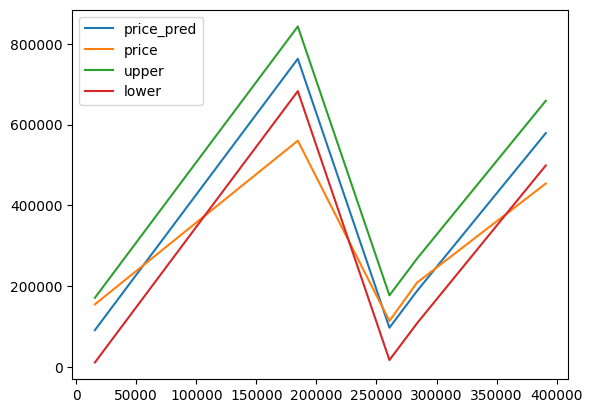

In [44]:
plt.figure(figsize = (25,5))
df_prediction[['price_pred', 'price', 'upper', 'lower']].sample(5).sort_index().plot()

<AxesSubplot:xlabel='price', ylabel='Count'>

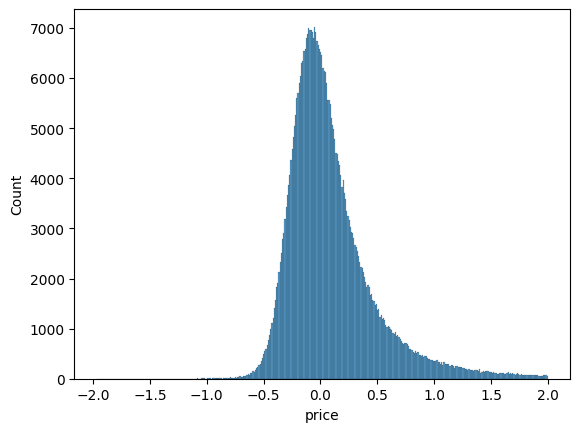

In [47]:
diff = (y_pred - y_test.price)/y_test.price
sns.histplot(diff[(diff<2) & (diff >-2)])

<AxesSubplot:xlabel='price', ylabel='Count'>

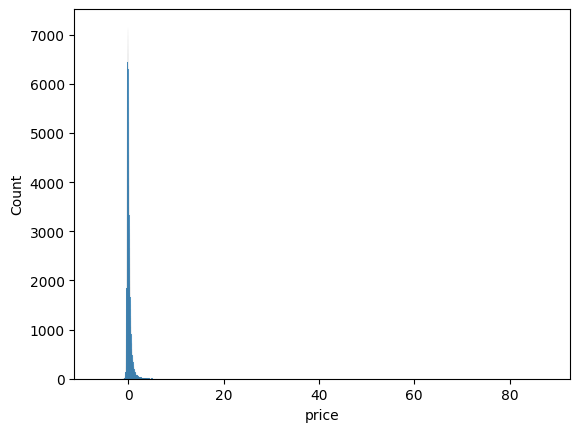

In [72]:
diff = (y_pred - y_test.price)/y_test.price
sns.histplot(diff)

## Another try

In [67]:
df_y_pred = pd.DataFrame(y_pred)
df_y_test = pd.DataFrame(y_test).reset_index().drop(columns = 'index')
df_y_pred.columns = ['price_pred']
df_y_pred['upper'] = df_y_pred.price_pred*1.3
df_y_pred['lower'] = df_y_pred.price_pred*0.7
df_prediction = pd.concat([df_y_pred, df_y_test], axis = 1)
df_prediction['in_range'] = (df_prediction.price < df_prediction.upper) & (df_prediction.price > df_prediction.lower)

df_prediction.head()

,price_pred,upper,lower,price,in_range
0,430941.656250,560224.125000,301659.156250,547440.0,True
1,316196.281250,411055.156250,221337.390625,265000.0,True
2,276154.531250,359000.875000,193308.171875,233980.0,True
3,139381.734375,181196.250000,97567.210938,100000.0,True
4,197232.546875,256402.296875,138062.781250,218500.0,True


<AxesSubplot:>

<Figure size 2500x500 with 0 Axes>

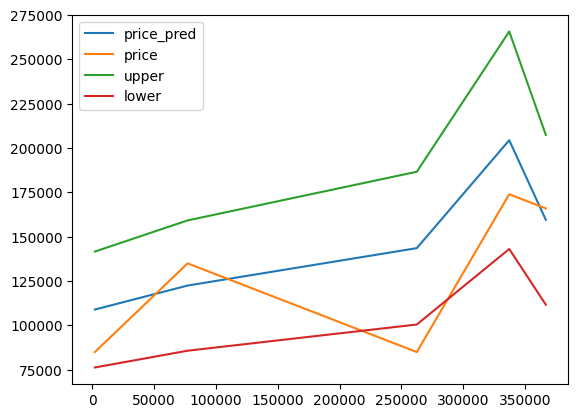

In [68]:
plt.figure(figsize = (25,5))
df_prediction[['price_pred', 'price', 'upper', 'lower']].sample(5).sort_index().plot()

In [69]:
df_prediction.in_range.sum() / len(df_prediction)

0.6981608441843759

<AxesSubplot:>

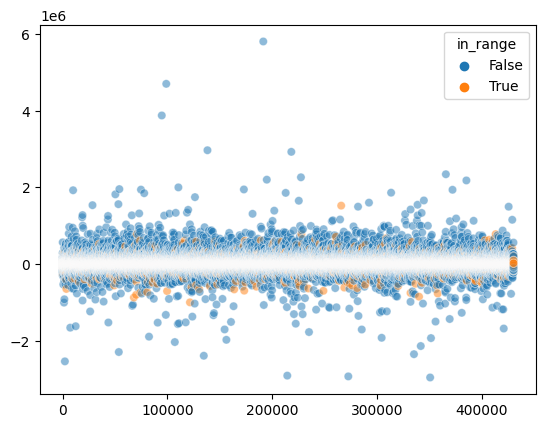

In [70]:
sns.scatterplot(y = df_prediction.price-df_prediction.price_pred, x = df_prediction.index, hue = df_prediction.in_range, alpha = 0.5)

<AxesSubplot:xlabel='price', ylabel='price_pred'>

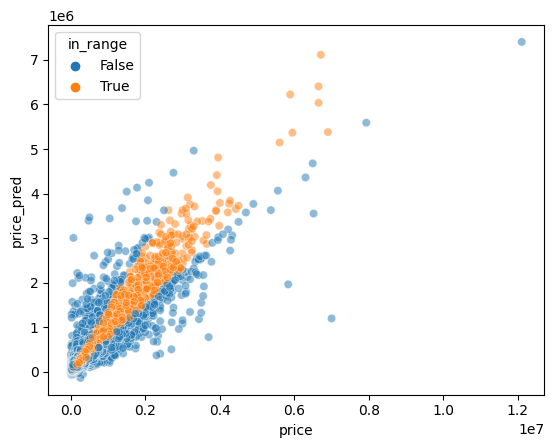

In [71]:
sns.scatterplot(df_prediction.price, df_prediction.price_pred, hue = df_prediction.in_range,alpha = 0.5)

## 📈 Linear Regression on data without outliers (df_without_outliers)

In [80]:
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()

model_lin.fit(X_train_preproc, y_train)
y_pred = model_lin.predict(X_test_preproc)
mse_b = mean_squared_error(y_pred, y_test)
rmse_b = mse_b**(1/2)
print(f'Root Mean Squared Error: {rmse_b}')
print( 'Train score (R²):', model_lin.score(X_train_preproc, y_train))
print('Cross val score mean (R²) :', cross_val_score(model_lin, X_all, y_all, cv = 5).mean())

Root Mean Squared Error: 106549.40586959607
Train score (R²): 0.5737440603554238


Cross val score mean (R²) : 0.567642564406856


# No need anymore

## 🌳 RandomForest on full data of 93 (df_clean)

In [81]:
#preprocess data
X_train_preproc_2, X_test_preproc_2, y_train_2, y_test_2, X_all_2, y_all_2, df_full_2 = preprocess_data(df_clean)

In [82]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_2 = RandomForestRegressor()

model_rfr_2.fit(X_train_preproc_2, y_train_2)
y_pred_2 = model_rfr_2.predict(X_test_preproc_2)
mse_2a = mean_squared_error(y_test_2, y_pred_2)
rmse_2a = mse_2a**(1/2)
print(f'Root Mean Squared Error: {rmse_2a}')
print( 'Train score:', model_rfr_2.score(X_test_preproc_2, y_test_2))
print('Cross val score mean', cross_val_score(model_rfr_2, X_all_2, y_all_2, cv = 5).mean())

Root Mean Squared Error: 403915.8565178672
Train score: 0.03060401565035431


## 🪃 XGBoost on full data (df_clean)

In [ ]:
model_xgb_2 = XGBRegressor()

model_xgb_2.fit(X_train_preproc_2, y_train_2)
y_pred_2 = model_xgb_2.predict(X_test_preproc_2)
mse_2b = mean_squared_error(y_pred_2, y_test_2)
rmse_2b = mse_2b**(1/2)
print(f'Root Mean Squared Error: {rmse_2b}')
print( 'Train score:', model_xgb_2.score(X_train_preproc_2, y_train_2))
print('Cross val score mean (r2) :', cross_val_score(model_xgb_2, X_all_2, y_all_2, cv = 5, scoring = 'r2').mean())

Root Mean Squared Error: 469551.9651230555
Train score: 0.9344138380463474
Cross val score mean (r2) : -0.0726894111511023


## 📈 Linear Regression on full data (df_clean)

In [ ]:
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()

model_lin.fit(X_train_preproc_2, y_train_2)
y_pred_2 = model_lin.predict(X_test_preproc_2)
mse_2b = mean_squared_error(y_pred_2, y_test_2)
rmse_2b = mse_2b**(1/2)
print(f'Mean Squared Error: {rmse_2b}')
print( 'Train score:', model_lin.score(X_train_preproc_2, y_train_2))
print('Cross val score mean', cross_val_score(model_lin, X_all_2, y_all_2, cv = 5).mean())

Mean Squared Error: 513551.2280835766
Train score: 0.1093884854827537
Cross val score mean 0.12753373904734266


## What model should we use ?

In [ ]:
model_xgb_2 = XGBRegressor()

model_xgb_2.fit(X_train_preproc_2, y_train_2)
y_pred_2 = model_xgb_2.predict(X_test_preproc_2)
mse_2b = mean_squared_error(y_pred_2, y_test_2)
rmse_2b = mse_2b**(1/2)
print(f'Root Mean Squared Error: {rmse_2b}')
print( 'Train score:', model_xgb_2.score(X_train_preproc_2, y_train_2))
print('Cross val score mean (r2) :', cross_val_score(model_xgb_2, X_all_2, y_all_2, cv = 5, scoring = 'r2').mean())

# download file

In [ ]:
df_without_outliers.to_pickle('../raw_data/dvf_93_cleaned.pkl')

# end of doc

In [ ]:
df_full_clean = pd.read_pickle('../raw_data/dvf_full_cleaned.pkl')

NameError: name 'df_full_clean' is not defined

In [16]:
df_full_clean.shape, df_full_clean.columns

((1433810, 17),
 Index(['postal_code', 'date', 'built', 'price', 'city', 'region',
        'property_type', 'living_area', 'number_of_rooms', 'longitude',
        'latitude', 'nb_of_dep', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
        'year'],
       dtype='object'))

In [109]:
import sys
sys.path.append('/home/anouchka/code/qadnguyen/realdata')
from prop_value.ml_logic.preprocessor import preprocess_input
preprocess_input(df_full_clean)

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/preprocessing_pipeline.pkl'

In [5]:
df93_clean = clean_data(df_93_raw)

In [7]:
from xgboost import XGBRegressor
xgb_model_loaded = XGBRegressor()
xgb_model_loaded.load_model('../raw_data/xgb_model_2.bin')

In [8]:
xgb_model_loaded

XGBRegressor(base_score=210485.8, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [11]:
pip install shap

  Using cached shap-0.44.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
Using cached shap-0.44.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (535 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 417.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 417.7 kB/s eta 0:00:0000:0100:03

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import shap
shap.initjs()

In [13]:
X_test_preproc = pd.read_pickle('../raw_data/X_test_preproc')

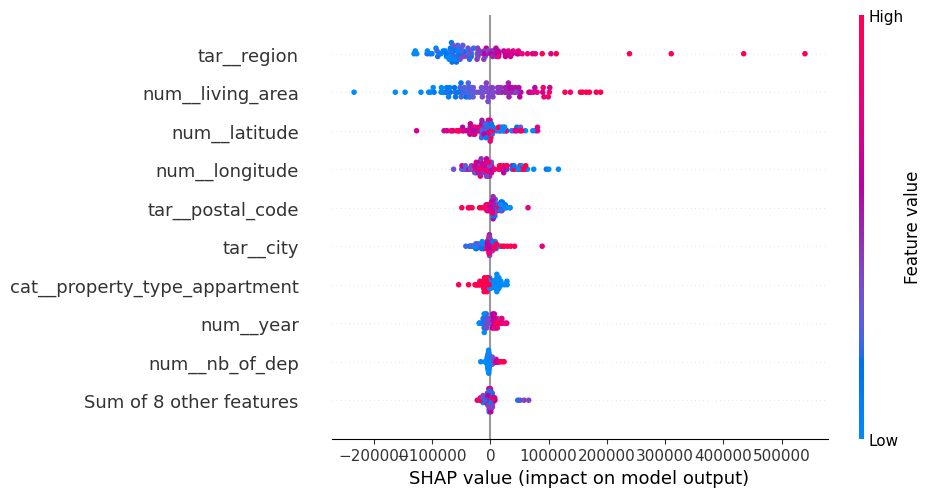

In [15]:
explainer = shap.Explainer(xgb_model_loaded)
shap_values = explainer(X_test_preproc)
shap.plots.beeswarm(shap_values)

In [ ]:
df_full_clean.shape